# Diabetic patients readmission rates preditction


In [470]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize
from sklearn import datasets as skdataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset

from learn2learn.algorithms.maml import MAML
from learn2learn.data import TaskDataset

from tqdm import tqdm

# Project introduction

- Overview: <br>
This project is focusing on developing a predictive model to ascertain the likelihood of readmission for diabetes patients.
<br>

- Target:<br>
The main goal of this project is developing a powerful machine learning model which can predict the readmission rate of patient 

# Data loading
The following cells are used to load training and testing data for our prediction

In [400]:
train_data = pd.read_csv("Dataset/diabetic_data_training.csv")
test_data = pd.read_csv("Dataset/diabetic_data_test.csv")
mapping_info = pd.read_csv("Dataset/IDS_mapping.csv", header=None)
pd.set_option('display.max_columns', None)

In [401]:
# Function to handle different data types for plotting
def plot_column(ax, column, df):
    if df[column].dtype == 'object':
        # Check if binary
        if df[column].nunique() == 2:
            # Binary data visualization
            df[column].value_counts().plot(kind='bar', ax=ax)
        else:
            # Categorical data visualization
            df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax)
    elif df[column].dtype == 'int64' or df[column].dtype == 'float64':
        # Numeric data visualization
        df[column].plot(kind='hist', bins=20, ax=ax)
    else:
        ax.text(0.5, 0.5, f"Unhandled data type for column: {column}", 
                fontsize=12, ha='center')
    ax.set_title(column)



In [402]:
# fig, axes = plt.subplots(nrows=13, ncols=4, figsize=(20, 65))
# fig.tight_layout(pad=5.0)


# for i, col in enumerate(train_data.columns):

#     plot_column(axes[i//4, i%4], col,train_data)


# plt.show()

# Data preprocessing
The following cells are used to preprocess the training and testing data. There are two main goals in our preprocessing data section of the code
- Change the string type data in our dataset to integer type data 
- Apply some applicable method to full up the missing value

In [403]:
# this part is used to change all string type data to integer type
# for the missing value, we will skip and process it at next step

# df = train_data.copy()

# df.drop(columns = ['weight','encounter_id','patient_nbr', 'examide', 'citoglipton',
# 'glimepiride-pioglitazone'],inplace=True)
# df.replace('?', np.nan, inplace=True)

# df_test = test_data.copy()
# df_test.drop(columns = ['weight','encounter_id','patient_nbr', 'examide', 'citoglipton',
# 'glimepiride-pioglitazone'],inplace=True)
# df_test.replace('?', np.nan, inplace=True)
df = train_data.copy()
df_test = test_data.copy()

One-Hot Encoding For race:
cons: One-hot encoding can lead to a significant increase in the dataset's dimensionality (a problem known as the "curse of dimensionality"), especially if the categorical feature has many unique values. This can increase the computational cost and may require more data to achieve good performance.
Dems Redct Would be apply, so it doesn't matter
pros: Map to a fix number implies an ordinal relationship between the categories which may not exist, but is ideal for non-ordinal categorical data. It's suitable for many machine learning models, especially those that assume no ordinal relationship between categories

Race Process
1. Remove missing since race is proved to be a significant impact to medical result.
2. One-hot encode race

In [404]:
def race_filter(df):
    """
    Remove missing value from race
    
    Parameters:
    df (pandas.dataframe): series containing a colum of the feature matrix.

    Return:
    Filtered dataframe free from ? for race
    """
    race_mask = (df['race'] != "?")
    df = df[race_mask]
    return df

In [405]:
df = race_filter(df)
df_encoded = pd.get_dummies(df, columns=["race"], prefix="race",dtype=int)

df_test = race_filter(df_test)
df_test_encoded = pd.get_dummies(df_test, columns=["race"], prefix="race",dtype=int)

Gender Process

1. Remove Unknown/Invalid and missing
2. One hot encode Gender

In [406]:
def gender_filter(df):
    """
    Remove missing value from race
    
    Parameters:
    df (pandas.dataframe): series containing a colum of the feature matrix.

    Return:
    Filtered dataframe free from ? for race
    """
    gender_mask = (df['gender'] != "Unknown/Invalid")
    df = df[gender_mask]
    return df

In [407]:
df_encoded = gender_filter(df_encoded)
df_test_encoded = gender_filter(df_test_encoded)
gender_mapping = {'Male':0,'Female':1}
df_encoded['gender'] = df_encoded['gender'].map(gender_mapping)
df_test_encoded['gender'] = df_test_encoded['gender'].map(gender_mapping)

encounter_id and patient_nbr Process 
1. n/a
2. Drop since it provide no info to the result

In [408]:
df_encoded.drop(columns=['encounter_id','patient_nbr'], inplace=True)
df_test_encoded.drop(columns=['encounter_id','patient_nbr'],inplace=True)

Age Process
1. n/a
2. Map age from range to mean

In [409]:
df_encoded['age'] = (df['age'].str.extract(r'(\d+)-(\d+)')[0].astype(int)+df['age'].str.extract(r'(\d+)-(\d+)')[1].astype(int))//2
df_test_encoded['age'] = (df_test['age'].str.extract(r'(\d+)-(\d+)')[0].astype(int)+df_test['age'].str.extract(r'(\d+)-(\d+)')[1].astype(int))//2

Weight Process
1. Drop Weight for too many missing values and no information to predict.
2. n/a

In [410]:
df_encoded.drop(columns=['weight'], inplace=True)
df_test_encoded.drop(columns=['weight'], inplace=True)

num_lab_procedures num_procedures num_medications number_outpatient number_emergency number_inpatient No need to be encode since no missing and integer.

diag_1,diag_2 and diag_3 Process:

Filte diag_1, diag_2 and diag_3 by number_diagnoses. If the amount of diagnoses in diag_1, diag_2 and diag_3 doesn't match the number_diagnoses, then remove.
Layer encoding diags according to the ICD-9 Code Category, drop original 3 diag

In [411]:
def diag_missing_value_filter(df):

    df['number_diagnoses'] = pd.to_numeric(df['number_diagnoses'], errors='coerce')
    mask = ((df['number_diagnoses'] <= 3) & (
            (3 - df[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: x == "?").sum(axis=1)) >= df['number_diagnoses'])) | (
    (df['number_diagnoses'] > 3) & (df[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: x == "?").sum(axis=1)) == 0) 
    df_filtered = df[mask].copy()

    return df_filtered

def diag_layer_encoding(df):

    # Define the encoding function
    def encode_element(element):
        encoding_result = [0] * 20  # Default encoding

        if pd.notna(element):
            if element[0].isdigit():
                element = float(element)
                # Encode based on numeric range
                if 1 <= element <= 139:
                    encoding_result[0] = 1
                elif 140 <= element <= 239:
                    encoding_result[1] = 1
                elif 240 <= element <= 279:
                    encoding_result[2] = 1
                elif 280 <= element <= 289:
                    encoding_result[3] = 1
                elif 290 <= element <= 319:
                    encoding_result[4] = 1
                elif 320 <= element <= 389:
                    encoding_result[5] = 1
                elif 390 <= element <= 459:
                    encoding_result[6] = 1
                elif 460 <= element <= 519:
                    encoding_result[7] = 1
                elif 520 <= element <= 579:
                    encoding_result[8] = 1
                elif 580 <= element <= 629:
                    encoding_result[9] = 1
                elif 630 <= element <= 679:
                    encoding_result[10] = 1
                elif 680 <= element <= 709:
                    encoding_result[11] = 1
                elif 710 <= element <= 739:
                    encoding_result[12] = 1
                elif 740 <= element <= 759:
                    encoding_result[13] = 1
                elif 760 <= element <= 779:
                    encoding_result[14] = 1
                elif 780 <= element <= 799:
                    encoding_result[15] = 1
                elif 800 <= element <= 999:
                    encoding_result[16] = 1
                # Add more conditions for other ranges if needed
            elif element[0].isalpha():
                # Encode based on string prefix
                if element.startswith('E'):
                    encoding_result[17] = 1
                elif element.startswith('V'):
                    encoding_result[18] = 1
                elif element.startswith('M'):
                    encoding_result[19] = 1
                # Add more conditions for other prefixes if needed

        return encoding_result

    for i in range(1,4):
        encoded_columns = df["diag_"+str(i)].apply(encode_element)

    # Create new columns with "diag_1" as a prefix
        for j in range(20):
            new_column_name = "diag_" + str(i)+"_"+ str(j+1)
            df[new_column_name] = encoded_columns.apply(lambda x: x[j])

    return df


In [412]:
df_encoded = diag_missing_value_filter(df_encoded)
df_encoded = diag_layer_encoding(df_encoded)
df_test_encoded = diag_missing_value_filter(df_test_encoded)
df_test_encoded = diag_layer_encoding(df_test_encoded)

for i in range(1,4):
        df_encoded.drop(columns=[f'diag_{i}'], inplace=True)
        df_test_encoded.drop(columns=[f'diag_{i}'], inplace=True)

number_diagnoses pass since no missing and integer max_glu_serum and A1Cresult Process: 
1. n/a 
2. index map to 0-3



In [413]:
max_glu_serum_mapping = {'>200': 2, '>300': 3, 'normal': 1}
A1Cresult_mapping = {'>8':3,'>7':2,'normal':1}

In [414]:
df_encoded['max_glu_serum'] = df_encoded['max_glu_serum'].map(max_glu_serum_mapping).fillna(0)
df_test_encoded['max_glu_serum'] = df_test_encoded['max_glu_serum'].map(max_glu_serum_mapping).fillna(0)

df_encoded["A1Cresult"] = df_encoded['A1Cresult'].map(A1Cresult_mapping).fillna(0)
df_test_encoded["A1Cresult"] = df_test_encoded['A1Cresult'].map(A1Cresult_mapping).fillna(0)

metformin repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide examide citoglipton insulin glyburide-metformin glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone Process:

1. drop 'examide', 'citoglipton','glimepiride-pioglitazone' and 'metformin-rosiglitazone' since single value observed
2. index map to 0-3

In [415]:
df_encoded.drop(columns=['examide', 'citoglipton','glimepiride-pioglitazone','metformin-rosiglitazone'],axis=1,inplace=True)
df_test_encoded.drop(columns=['examide', 'citoglipton','glimepiride-pioglitazone','metformin-rosiglitazone'],axis=1,inplace=True)
medics = ['metformin','repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
        'metformin-pioglitazone']
for i in medics:
    df_encoded.loc[df_encoded[i] == 'Up', [i]] = 3  
    df_encoded.loc[df_encoded[i] == 'Down', [i]] = 1 
    df_encoded.loc[df_encoded[i] == 'Steady', [i]] = 2 
    df_encoded.loc[df_encoded[i] == 'No', [i]] = 0
    df_test_encoded.loc[df_test_encoded[i] == 'Up', [i]] = 3  
    df_test_encoded.loc[df_test_encoded[i] == 'Down', [i]] = 1 
    df_test_encoded.loc[df_test_encoded[i] == 'Steady', [i]] = 2 
    df_test_encoded.loc[df_test_encoded[i] == 'No', [i]] = 0 
 

change and diabetesMed Process

1. n/a
2. binary map to 1/0

In [416]:
change_mapping = {'No':0,'Ch':1}
diabetesMed_mapping = {'No':0,'Yes':1}

df_encoded['change'] = df_encoded['change'].map(change_mapping)
df_encoded['diabetesMed'] = df_encoded['diabetesMed'].map(diabetesMed_mapping)

df_test_encoded['change'] = df_test_encoded['change'].map(change_mapping)
df_test_encoded['diabetesMed'] = df_test_encoded['diabetesMed'].map(diabetesMed_mapping)

readmitted Process: 
1. n/a 
2. index mapping, No as 0, >30 as 1 and <30 as most significant as 2 and drop readmitted for test

In [417]:
readmitted_mapping = {'NO':0,'<30':2,'>30':1}
df_encoded['readmitted'] = df_encoded['readmitted'].map(readmitted_mapping)
df_test_encoded['readmitted'] = df_test_encoded['readmitted'].map(readmitted_mapping)

y_test_readmitted = df_encoded["readmitted"]
y_readmitted = df_test_encoded["readmitted"]

df_encoded.drop(columns=["readmitted"],axis=1,inplace=True)
df_test_encoded.drop(columns=["readmitted"],axis=1,inplace=True)

'admission_type_id','discharge_disposition_id','admission_source_id' Process:
1. n/a
2. target encoding

In [418]:
X_train = df_encoded
Y_train = y_test_readmitted

features = ['admission_type_id','discharge_disposition_id','admission_source_id']

'''for name in names:
    category_means = df_encoded.groupby(name)['readmitted'].mean().reset_index()
    category_means.columns = [name,name+'_readmitted_Mean']
    df_encoded = pd.merge(df_encoded, category_means, on=name, how='left')
    df_encoded = df_encoded.drop(name, axis=1)'''


for feature in features:
    
    mean_col_name = f'{feature}_Encoded'
    means = X_train.join(Y_train).groupby(feature)['readmitted'].mean()
    df_encoded[mean_col_name] = df_encoded[feature].map(means)
    df_test_encoded[mean_col_name] = df_test_encoded[feature].map(means)

    df_encoded = df_encoded.drop(feature, axis=1)
    df_test_encoded = df_test_encoded.drop(feature, axis=1)

Payer Code and medical_specialty Process:
1.1 index encoding payer code
1.2 RandomForestClassifier fill missing


1.3 KNN filling missing

2. target encoding

In [419]:
def payer_code_index_encoding(df):
    df.loc[df['payer_code'] == 'MD', ['payer_code']] = 1
    df.loc[df['payer_code'] == 'MC', ['payer_code']] = 2
    df.loc[df['payer_code'] == 'HM', ['payer_code']] = 3
    df.loc[df['payer_code'] == 'UN', ['payer_code']] = 4
    df.loc[df['payer_code'] == 'BC', ['payer_code']] = 5
    df.loc[df['payer_code'] == 'CP', ['payer_code']] = 6
    df.loc[df['payer_code'] == 'SP', ['payer_code']] = 7
    df.loc[df['payer_code'] == 'SI', ['payer_code']] = 8
    df.loc[df['payer_code'] == 'CM', ['payer_code']] = 9
    df.loc[df['payer_code'] == 'DM', ['payer_code']] = 10
    df.loc[df['payer_code'] == 'CH', ['payer_code']] = 11
    df.loc[df['payer_code'] == 'PO', ['payer_code']] = 12
    df.loc[df['payer_code'] == 'WC', ['payer_code']] = 13
    df.loc[df['payer_code'] == 'OG', ['payer_code']] = 14
    df.loc[df['payer_code'] == 'OT', ['payer_code']] = 15
    df.loc[df['payer_code'] == 'MP', ['payer_code']] = 16
    df.loc[df['payer_code'] == 'FR', ['payer_code']] = 17
    return df

In [420]:
df_encoded = payer_code_index_encoding(df_encoded)
df_test_encoded = payer_code_index_encoding(df_test_encoded)

In [421]:
df_encoded['payer_code'].value_counts()

payer_code
?     35739
2     28319
3      5512
7      4281
5      4056
1      3092
6      2215
4      2051
9      1721
14      922
12      526
10      477
11      130
13      116
15       83
16       68
8        53
Name: count, dtype: int64

In [422]:
#separating the columns that contain null values and need to predicted.
payer_code_col = ['payer_code']
medical_specialty_cols = ['medical_specialty']
other_cols = list(df_encoded.columns)
other_cols.remove("payer_code")
other_cols.remove("medical_specialty")

Random Forst

In [423]:
payer_code_mask = (df_encoded["payer_code"] != "?")
df_notnans = df_encoded[payer_code_mask]

X_train, X_test, y_train, y_test = train_test_split(df_notnans[other_cols], df_notnans[payer_code_col].astype(int),
                                                    train_size=0.75,
                                                    random_state=1)

rf = RandomForestClassifier()
paramsgrid  = {'n_estimators': [100,200,400],
               'max_depth': [25, 30,50,100],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [2, 5, 10]
 }

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = paramsgrid, n_iter = 5, cv = 3, verbose=2, random_state=1, n_jobs = -1)
 
rf_random.fit(X_test, y_test.values.ravel())

Fitting 3 folds for each of 5 candidates, totalling 15 fits


375447.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
375447.99s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
375448.02s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
375448.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
375448.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
375448.07s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
375448.09s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
375448.11s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   4.9s
[CV] END max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   5.0s
[CV] END max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   5.0s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=  10.8s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=  10.9s
[CV] END max_depth=100, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  10.3s
[CV] END max_depth=100, min_samples_leaf=1, min_samples_split=10, n_estimators=40

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': [25, 30, 50, 100],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 400]},
                   random_state=1, verbose=2)

In [424]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 100}

In [425]:
rf1 =(RandomForestClassifier(max_depth=100,n_estimators = 400,min_samples_leaf=1,min_samples_split=10))
rf1.fit(X_train, y_train.values.ravel())
score = rf1.score(X_test, y_test.values.ravel())

print(f"Score is {score}")

Score is 0.5643741608235119


KNN filling

In [426]:
train_score = []
test_score = []

for i in range(6,30,2):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train.values.ravel())
    
    train_score.append(knn.score(X_train,y_train.values.ravel()))
    test_score.append(knn.score(X_test,y_test.values.ravel()))

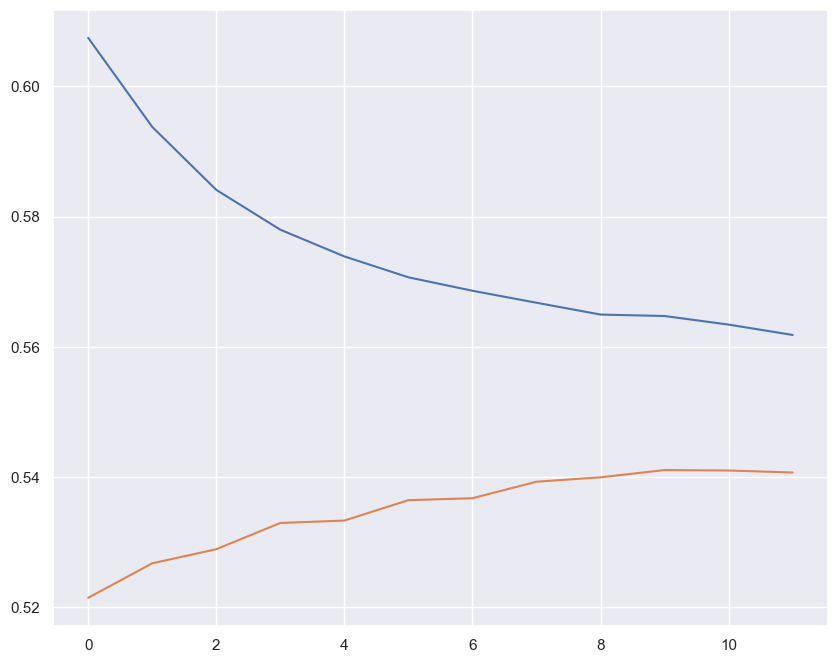

In [427]:
plt.plot(train_score)
plt.plot(test_score)

In [428]:
knn2 =(KNeighborsClassifier(n_neighbors= 21))
# # Fit on the train data
knn2.fit(X_train, y_train.values.ravel())

# # Check the prediction score
score = knn2.score(X_test, y_test.values.ravel())
print(f"Thescore on the testset is {score}")

Thescore on the testset is 0.539236162912129


Hist Gradient Boosting prediction

In [429]:

HGB_classifier = HistGradientBoostingClassifier(max_iter=100)
HGB_classifier.fit(X_train,y_train)

/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingClassifier()

In [430]:
score = HGB_classifier.score(X_test, y_test.values.ravel())

print(f"Score is {score}")

Score is 0.5605698940772789


In [431]:
payer_code_predicting_index = df_encoded.index[df_encoded["payer_code"] == "?"]
df_encoded['payer_code'].loc[payer_code_predicting_index] = rf1.predict(df_encoded[other_cols].loc[payer_code_predicting_index])

test_payer_code_predicting_index = df_test_encoded.index[df_test_encoded["payer_code"] == "?"]
df_test_encoded['payer_code'].loc[test_payer_code_predicting_index] = rf1.predict(df_test_encoded[other_cols].loc[test_payer_code_predicting_index])

/var/folders/wy/3sxd9blx6bxgs72tmypqqrzr0000gn/T/ipykernel_26725/421159950.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded['payer_code'].loc[payer_code_predicting_index] = rf1.predict(df_encoded[other_cols].loc[payer_code_predicting_index])
/var/folders/wy/3sxd9blx6bxgs72tmypqqrzr0000gn/T/ipykernel_26725/421159950.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_encoded['payer_code'].loc[test_payer_code_predicting_index] = rf1.predict(df_test_encoded[other_cols].loc[test_payer_code_predicting_index])


In [432]:
df_encoded['payer_code'].value_counts()

payer_code
2     58564
3      7817
5      5620
7      5317
1      3624
6      2231
4      2084
9      1721
14      929
12      526
10      478
11      130
13      116
15       83
16       68
8        53
Name: count, dtype: int64

Predict and target encoding medical_specialty

In [433]:
category_mapping = {category: i for i, category in enumerate(df_encoded['medical_specialty'].unique())}
df_encoded['medical_specialty'] = df_encoded['medical_specialty'].map(category_mapping)
df_test_encoded['medical_specialty'] = df_test_encoded['medical_specialty'].map(category_mapping)

In [434]:
medical_specialty_mask = (df_encoded["medical_specialty"] != 0)
df_notnans = df_encoded[medical_specialty_mask]

index = df_notnans.index[df_notnans['medical_specialty'].duplicated(keep=False)]
df_notnans = df_notnans.loc[index]


X_train, X_test, y_train, y_test = train_test_split(df_notnans[other_cols], df_notnans[medical_specialty_cols].astype(int),
                                                    train_size=0.75,
                                                    random_state=1)
index = y_train.index[y_train.duplicated(keep=False)]
X_train = X_train.loc[index]
y_train = y_train.loc[index]

In [435]:
rf1 =(RandomForestClassifier(max_depth=100,n_estimators = 400,min_samples_leaf=1,min_samples_split=10))
rf1.fit(X_train, y_train.values.ravel())
print(rf1.score(X_test,y_test))


0.540436005625879


In [436]:
HGB_classifier = HistGradientBoostingClassifier(max_iter=100)
HGB_classifier.fit(X_train,y_train)
score = HGB_classifier.score(X_test, y_test.values.ravel())

print(f"Score is {score}")

/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score is 0.4153481012658228


In [437]:
train_score = []
test_score = []

for i in range(60,90,2):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train.values.ravel())
    
    train_score.append(knn.score(X_train,y_train.values.ravel()))
    test_score.append(knn.score(X_test,y_test.values.ravel()))

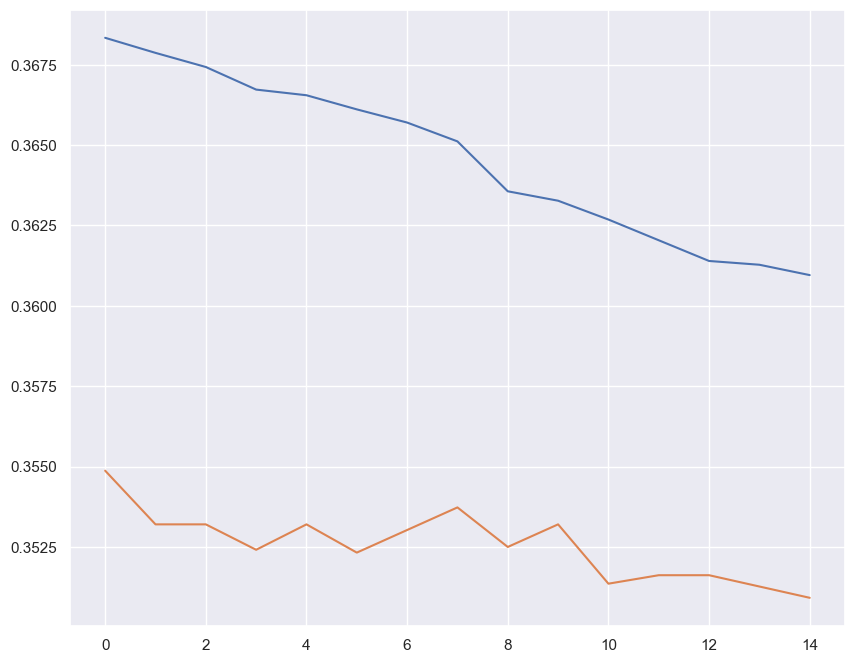

In [438]:
plt.plot(train_score)
plt.plot(test_score)

In [439]:
knn2 =(KNeighborsClassifier(n_neighbors= 80))
# # Fit on the train data
knn2.fit(X_train, y_train.values.ravel())

# # Check the prediction score
score = knn2.score(X_test, y_test.values.ravel())
print(f"Thescore on the testset is {score}")

Thescore on the testset is 0.3513537271448664


adding payer code and medical specialty

In [440]:
medical_specialty_predicting_index = df_encoded.index[df_encoded["medical_specialty"] == 0]
df_encoded['medical_specialty'].loc[medical_specialty_predicting_index] = rf1.predict(df_encoded[other_cols].loc[medical_specialty_predicting_index])

test_medical_specialty_predicting_index = df_test_encoded.index[df_test_encoded["medical_specialty"] == 0]
df_test_encoded['medical_specialty'].loc[test_medical_specialty_predicting_index] = rf1.predict(df_test_encoded[other_cols].loc[test_medical_specialty_predicting_index])

/var/folders/wy/3sxd9blx6bxgs72tmypqqrzr0000gn/T/ipykernel_26725/3127860092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded['medical_specialty'].loc[medical_specialty_predicting_index] = rf1.predict(df_encoded[other_cols].loc[medical_specialty_predicting_index])
/var/folders/wy/3sxd9blx6bxgs72tmypqqrzr0000gn/T/ipykernel_26725/3127860092.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_encoded['medical_specialty'].loc[test_medical_specialty_predicting_index] = rf1.predict(df_test_encoded[other_cols].loc[test_medical_specialty_predicting_index])


In [441]:
# this part will recognise the ?, the missing value in training data
# When we have recognised it, we will use **** method to full up it
# the method we can discuss: 
#   delete
#   mean,median or mode
#   knn to predict
#   Multiple Imputation

In [442]:

# predict_nan = df_encoded.copy()


# df_real_ms_index = predict_nan.index[predict_nan['medical_specialty'] != 0]
# unique_rows_index = predict_nan.index[predict_nan['medical_specialty'].duplicated(keep=False)]
# df_real_ms_index_total = df_real_ms_index.join(unique_rows_index,how = 'inner')

# df_real_pc_index = predict_nan.index[predict_nan['payer_code'] != 0]
# unique_rows_index = predict_nan.index[predict_nan['payer_code'].duplicated(keep=False)]
# df_real_pc_index_total = df_real_pc_index.join(unique_rows_index,how = 'inner')

# df_real_ms = predict_nan.loc[df_real_ms_index_total,['medical_specialty']]
# df_real_pc = predict_nan.loc[df_real_pc_index_total,['payer_code']]

# predict_nan.drop(columns = ['medical_specialty','payer_code'],inplace = True)

# df_data_train_ms = predict_nan.loc[df_real_ms_index_total]
# df_data_predict_ms = predict_nan.loc[~predict_nan.index.isin(df_real_ms_index)]

# df_data_train_pc = predict_nan.loc[df_real_pc_index_total]
# df_data_predict_pc = predict_nan.loc[~predict_nan.index.isin(df_real_pc_index)]

In [443]:
# # this part will reduce the dimension our training data

# missing_value_predict_model = HistGradientBoostingClassifier(max_iter=100)
# missing_value_predict_model.fit(df_data_train_ms,df_real_ms['medical_specialty'])
# df_encoded['medical_specialty'].loc[~df_encoded['medical_specialty'].index.isin(df_real_ms_index)] = missing_value_predict_model.predict(df_data_predict_ms)

# missing_value_predict_model = HistGradientBoostingClassifier(max_iter=100)
# missing_value_predict_model.fit(df_data_train_pc,df_real_pc)
# df_encoded['payer_code'].loc[~df_encoded['payer_code'].index.isin(df_real_pc_index)] = missing_value_predict_model.predict(df_data_predict_pc)

payer_code
2     6555
3      854
5      633
7      585
1      387
6      249
4      218
9      197
14     104
12      62
10      57
11      14
15      12
13       9
16       9
8        2
Name: count, dtype: int64

Dems Redct
1. PCA/PPCA
2. LDA/QDA
3. following to T-SNE
3. Autoencoders
4. Unsupervised Algorithmn

/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Text(0.5, 0, 't-SNE Axis 1')

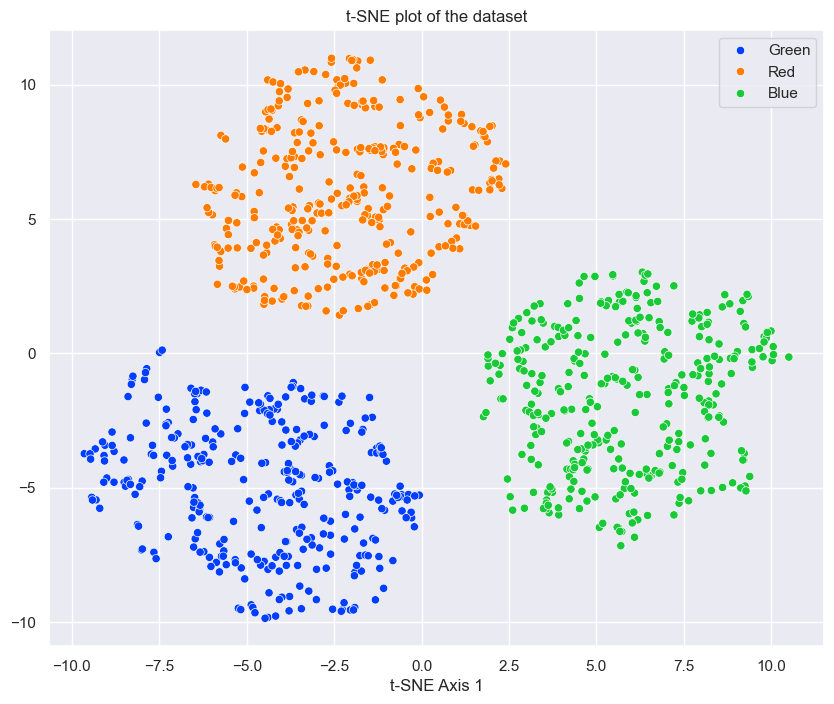

In [444]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Simulating Data
np.random.seed(0)
num_samples = 1000
num_features = 5

# Numerical data
numeric_data = np.random.randn(num_samples, num_features)

# Categorical data (let's say, colors)
colors = ['Red', 'Green', 'Blue']
categorical_data = np.random.choice(colors, size=num_samples)

# Convert categorical data to one-hot encoding
encoder = OneHotEncoder(sparse=False)
categorical_encoded = encoder.fit_transform(categorical_data.reshape(-1, 1))

# Combining numerical and categorical data
combined_data = np.hstack((numeric_data, categorical_encoded))

# Standardize the numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
pca_result = pca.fit_transform(scaled_data)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(pca_result)

# Plotting the results
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=categorical_data, palette='bright')
plt.title('t-SNE plot of the dataset')
plt.xlabel('t-SNE Axis 1')


In [445]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

input_shape = combined_data.shape[1]  # combined data from previous steps
encoding_dim = 32  # example of encoding dimension

# This is our input placeholder
input_data = Input(shape=(input_shape,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_data)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_shape, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(combined_data, combined_data, epochs=50, batch_size=256, shuffle=True)


Epoch 1/50
4/4 [==============================] - 0s 2ms/step - loss: 0.6563
Epoch 2/50
4/4 [==============================] - 0s 2ms/step - loss: 0.6319
Epoch 3/50
4/4 [==============================] - 0s 2ms/step - loss: 0.6080
Epoch 4/50
4/4 [==============================] - 0s 4ms/step - loss: 0.5840
Epoch 5/50
4/4 [==============================] - 0s 7ms/step - loss: 0.5602
Epoch 6/50
4/4 [==============================] - 0s 3ms/step - loss: 0.5365
Epoch 7/50
4/4 [==============================] - 0s 5ms/step - loss: 0.5130
Epoch 8/50
4/4 [==============================] - 0s 2ms/step - loss: 0.4894
Epoch 9/50
4/4 [==============================] - 0s 2ms/step - loss: 0.4657
Epoch 10/50
4/4 [==============================] - 0s 2ms/step - loss: 0.4423
Epoch 11/50
4/4 [==============================] - 0s 2ms/step - loss: 0.4184
Epoch 12/50
4/4 [==============================] - 0s 2ms/step - loss: 0.3945
Epoch 13/50
4/4 [==============================] - 0s 2ms/step - loss: 0.

# Model Building
We will build two models: 
1. A traditional machine learning model using Random Forest.
2. A deep learning model using PyTorch.


At the first step we will try to use the Random Forest method to get the result

In [446]:
# the code for Random Forest algorithm

In [447]:
# the code for Nerual Network

# Model Training


In [477]:
X = df_encoded
y = y_test_readmitted
X_test = df_test_encoded
y_test = y_readmitted


In [552]:
# training loop
# Random Forest
from sklearn.feature_selection import SelectKBest, chi2

# 选择最好的K个特征


HGB_classifier = HistGradientBoostingClassifier(max_iter=100)
HGB_classifier.fit(X, y)

# Nerual Network

HistGradientBoostingClassifier()

In [553]:
# use testing dataset to predict
Y_test = y_readmitted
#df_test_normalized = pd.DataFrame(scaler.fit_transform(df_test_encoded), columns=df_test_encoded.columns)
X_test = df_test_encoded
#X_test = selector.transform(X_test)

Y_pred = HGB_classifier.predict(X_test)
print(accuracy_score(Y_test,Y_pred))

0.5907308736302402


In [554]:

RF_classifier = RandomForestClassifier(n_estimators=100)
RF_classifier.fit(X, y)

RandomForestClassifier()

In [555]:
Y_pred = RF_classifier.predict(X_test)
print(accuracy_score(Y_test,Y_pred))

0.5834925103046145


In [549]:
k = 3  # 选择 K 值
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X,y)

KNeighborsClassifier(n_neighbors=3)

In [550]:
Y_pred = knn_classifier.predict(X_test)
print(accuracy_score(Y_test,Y_pred))

0.5024630541871922


In [551]:
from sklearn import svm
SVM_model = svm.SVC()
SVM_model.fit(X,y)
y_pred = SVM_model.predict(X_test)
print(accuracy_score(y_pred,y_test))

0.5627827485674073


In [481]:
# meta learning
np.random.seed(0)
torch.manual_seed(0)

# 模型配置
inner_lr = 0.01    # 内循环学习率
meta_lr = 0.001    # 元学习率
num_inner_updates = 1  # 每个任务的内部更新次数

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(50, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40,20),
            nn.Sigmoid(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.fc(x)

def maml_train_step(model, optimizer, data_loader):
    meta_loss = 0

    for task_data in data_loader:
        # 拆分数据为支持集和查询集
        support_set, query_set = task_data
        x_support, y_support = support_set
        x_query, y_query = query_set

        # 保存原始参数以便在每个任务后恢复
        original_state_dict = model.state_dict()

        # 内循环：在支持集上训练
        for _ in range(num_inner_updates):
            y_pred = model(x_support)
            loss = nn.CrossEntropyLoss()(y_pred, y_support)
            model.zero_grad()
            loss.backward()
            # 仅使用内循环学习率更新参数
            for param in model.parameters():
                param.data -= inner_lr * param.grad.data

        # 外循环：在查询集上评估并更新元参数
        y_pred_query = model(x_query)
        query_loss = nn.CrossEntropyLoss()(y_pred_query, y_query)
        meta_loss += query_loss

        # 恢复模型到原始状态
        model.load_state_dict(original_state_dict)

    # 更新元参数
    optimizer.zero_grad()
    meta_loss.backward()
    optimizer.step()

    return meta_loss.item()

# 实例化模型和优化器
model = Model()
optimizer = optim.Adam(model.parameters(), lr=meta_lr)


X_tensor = torch.tensor(X.astype(float).values, dtype=torch.float32)
y_tensor = torch.tensor(y.astype(int).values, dtype=torch.long)
train_dataset = TensorDataset(X_tensor, y_tensor)

X_test_tensor = torch.tensor(X_test.astype(float).values,dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.astype(int).values, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_data_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

num_epochs = 10
# 训练循环（伪代码，需要根据实际情况调整）
for epoch in tqdm(range(num_epochs)):
    meta_loss = maml_train_step(model, optimizer, train_data_loader)
    print(f"Epoch {epoch}: Meta Loss {meta_loss}")

if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":model}, "models/diabets_prediction_meta_learning.pth")

  0%|          | 0/10 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [538]:
class MLP(nn.Module):
    '''
    MLP class for predicting pixel values based on positions.
    '''
    def __init__(self, input_dimension, nb_layers, embedding_dimension, output_dimension):
        super(MLP, self).__init__()

        # Create a list to hold all layers
        layers = []

        # First layer
        layers.append(nn.Linear(input_dimension, embedding_dimension))
        layers.append(nn.Sigmoid())

        # Additional hidden layers
        for _ in range(nb_layers - 2):
            layers.append(nn.Linear(embedding_dimension, embedding_dimension))
            layers.append(nn.Sigmoid())

        # Output layer
        layers.append(nn.Linear(embedding_dimension, output_dimension))

        # Combine all layers
        self.layers = nn.Sequential(*layers)

    def forward(self, input):
        # Pass the input through all layers
        prediction = self.layers(input)

        return prediction

model = MLP(103,5,64,3)

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def loss_function(predict,target):
    loss_func = nn.CrossEntropyLoss()
    return loss_func(predict,target) 


X_tensor = torch.tensor(X.values.astype(float), dtype=torch.float32)
Y_dl = pd.get_dummies(Y)


y_tensor = torch.tensor(Y_dl.values.astype(float), dtype=torch.float32).squeeze(1)
print(y_tensor.shape)
print(y_tensor)


target_task_data = CustomDataset(X_tensor,y_tensor)  # Load your target task data
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = 'cpu'
model.to(device)
model.train()
for _ in range(30):
    for batch in tqdm(DataLoader(target_task_data, batch_size=1000, shuffle=True)):
        inputs, targets = batch
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = loss_function(predictions, targets)
        loss.backward()
        optimizer.step()

if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":model}, "models/diabets_prediction.pth")

torch.Size([89361, 3])
tensor([[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])


100%|██████████| 90/90 [00:00<00:00, 130.81it/s]


In [518]:
Y_dl[2]

0        False
1        False
2        False
3        False
4        False
         ...  
91584    False
91585    False
91586    False
91587    False
91588    False
Name: 2, Length: 89361, dtype: bool

In [539]:

X_test_tensor = torch.tensor(X_test.astype(float).values,dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.astype(float).values, dtype=torch.float32)
test_loader = TensorDataset(X_test_tensor, y_test_tensor)

model.eval()
total = 0
correct = 0
with torch.no_grad():
    for data in test_loader:  # 假设 test_loader 是测试数据的 DataLoader
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data,0)
        y_pred = predicted.item()
        total += 1
        if( y_pred == labels):
            correct += 1

accuracy = correct / total

In [540]:
print(accuracy)
print(correct)
print(total)

0.5749472202674173
5719
9947


# Model Evaluation